In [11]:
import pandas as pd  
df=pd.read_csv('diabetes.csv')
df.describe()
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
# 将0替换成均值
df[df.columns[:-1]]=df[df.columns[:-1]].mask(df==0).fillna(df.mean())

# 划分测试和训练集
train_size = 0.8
test_size = 1 - train_size
train_df, test_df = train_test_split(df, train_size=train_size, test_size=test_size, random_state=42)
# 指定要保存的 CSV 文件名
train_csv_filename = 'train_data.csv'
test_csv_filename = 'test_data.csv'
# 将分割后的 DataFrame 分别保存到 CSV 文件
train_df.to_csv(train_csv_filename, index=False)
test_df.to_csv(test_csv_filename, index=False)

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

groups = df.groupby('Outcome')
grouped_means = groups.mean()
print(grouped_means)

# 提取特征列（排除Outcome列）
features = df.drop('Outcome', axis=1).columns

# 标准化数据
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_df, columns=features)
scaled_df['Outcome'] = df['Outcome']

         Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
Outcome                                                                      
0           3.859378  110.705367      70.810008      25.373135  106.457354   
1           5.410866  142.159661      74.950326      28.907494  141.426597   

               BMI  DiabetesPedigreeFunction        Age  
Outcome                                                  
0        30.880066                  0.429734  31.190000  
1        35.381288                  0.550500  37.067164  


D:\anacon\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
D:\anacon\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
D:\anacon\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
D:\anacon\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thread

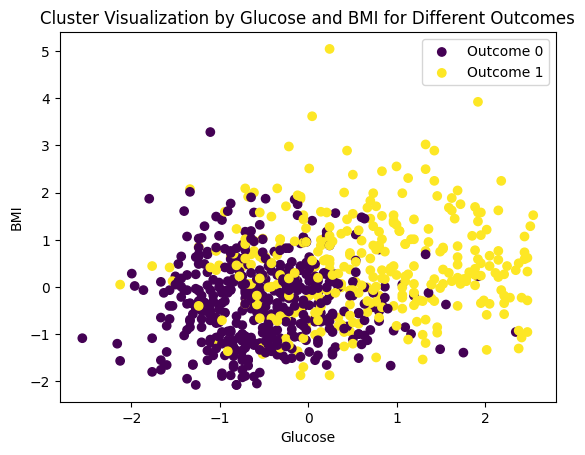

In [4]:
# 尝试不同聚类数量并计算轮廓系数
silhouette_scores = []
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df[features])
    silhouette_avg = silhouette_score(scaled_df[features], cluster_labels)
    silhouette_scores.append(silhouette_avg)

kmeans = KMeans(n_clusters=2, random_state=1)
scaled_df['Cluster'] = kmeans.fit_predict(scaled_df[features])

# 例如以Glucose和BMI两个特征为例可视化聚类结果（可以替换为其他更合适的特征组合展示）
plt.scatter(scaled_df[scaled_df['Outcome'] == 0]['Glucose'], scaled_df[scaled_df['Outcome'] == 0]['BMI'], c=scaled_df[scaled_df['Outcome'] == 0]['Cluster'], label='Outcome 0')
plt.scatter(scaled_df[scaled_df['Outcome'] == 1]['Glucose'], scaled_df[scaled_df['Outcome'] == 1]['BMI'], c=scaled_df[scaled_df['Outcome'] == 1]['Cluster'], label='Outcome 1')
plt.xlabel('Glucose')
plt.ylabel('BMI')
plt.title('Cluster Visualization by Glucose and BMI for Different Outcomes')
plt.legend()
plt.show()

In [5]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# 将数据转换为适合关联分析的格式
transactions = []
for i in range(len(df)):
    row = []
    for col in df.columns:
        if col!= 'Outcome':
            value = df.iloc[i][col]
            row.append((col, value))
    transactions.append(row)

# 对数据进行编码
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df1 = pd.DataFrame(te_ary, columns=te.columns_)

# 设置最小支持度
min_support = 0.1

# 运行Apriori算法
frequent_itemsets = apriori(df1, min_support=min_support, use_colnames=True)
# 生成关联规则
rules = association_rules(frequent_itemsets,  num_itemsets=None, metric="confidence", min_threshold=0.7)
# 查看关联规则
print(rules)

                             antecedents                     consequents  \
0  ((SkinThickness, 20.536458333333332))  ((Insulin, 79.79947916666667))   

   antecedent support  consequent support   support  confidence      lift  \
0            0.295573            0.486979  0.295573         1.0  2.053476   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
0               1.0  0.151635         inf       0.728281  0.606952        1.0   

   kulczynski  
0    0.803476  


0.7532468
0.7662338
0.7597403
0.7792208
0.7597403
0.7467532
0.7532468
0.7532468
avg: 75.89 maxV: 77.92 minV: 74.68


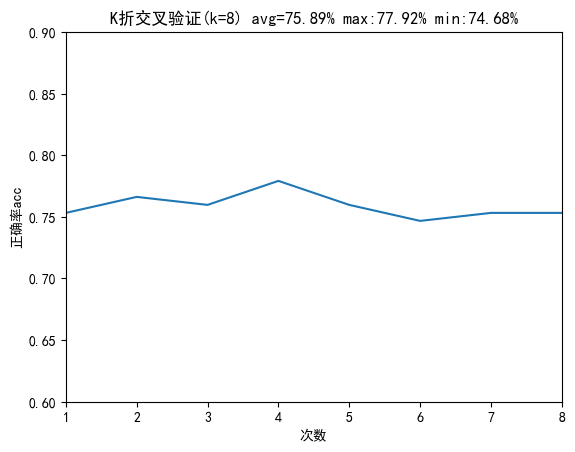

In [6]:
# K折交叉检验
from sklearn.svm import SVC # 导入支持向量机分类器
from sklearn.utils import shuffle # 用于打乱数据
from sklearn.model_selection import KFold # 用于实现K折交叉验证
plt.rcParams['font.sans-serif'] = ['SimHei']

dff = pd.read_csv("./train_data.csv")
dff_test = pd.read_csv("./test_data.csv")
# 构建训练集特征和目标向量
train = []
target = []
								
for i in range(0, len(dff["Outcome"])):
    mid = []
    mid.append(dff["Pregnancies"][i]) # 怀孕次数
    mid.append(dff["Glucose"][i]) # 葡萄糖
    mid.append(dff["BloodPressure"][i]) # 血压
    mid.append(dff["SkinThickness"][i]) # 皮肤厚度
    mid.append(dff["Insulin"][i]) # 胰岛素
    mid.append(dff["BMI"][i]) # 身体质量指数
    mid.append(dff["DiabetesPedigreeFunction"][i]) # 糖尿病家族史函数
    mid.append(dff["Age"][i]) # 年龄
    target.append(dff["Outcome"][i]) # 是否患病
    train.append(mid)
train = np.array(train)
target = np.array(target)

# 构建测试集特征和目标向量
test = []
test_target = []
for i in range(0, len(dff_test["Outcome"])):
    mid = []
    mid.append(dff_test["Pregnancies"][i]) 
    mid.append(dff_test["Glucose"][i])
    mid.append(dff_test["BloodPressure"][i])
    mid.append(dff_test["SkinThickness"][i])
    mid.append(dff_test["Insulin"][i])
    mid.append(dff_test["BMI"][i])
    mid.append(dff_test["DiabetesPedigreeFunction"][i])
    mid.append(dff_test["Age"][i])
    test_target.append(dff_test["Outcome"][i])
    test.append(mid)
test = np.array(test)

# 随机打乱训练集数据
train, target = shuffle(train, target)
# 构建K折交叉验证
index = [] # 用于存储每次训练的索引
value = [] # 用于存储每次训练的准确率
i = 1 # 训练轮次计数器
kf_size = 8 # K折交叉验证的分组数
kf = KFold(n_splits=kf_size) # 初始化KFold对象

# 开始SVM训练
for train_index, test_index in kf.split(train):
# 划分训练集和验证集
 trainx = train[train_index] # 训练数据的特征
 trainy = target[train_index] # 训练数据的目标
 testx = train[test_index] # 验证数据的特征
 testy = target[test_index] # 验证数据的目标

 # 初始化支持向量机模型，使用线性核，惩罚参数C=0.1
 svc = SVC(kernel='linear', C=0.1)
 clf = svc.fit(trainx, trainy) # 训练模型

 # 测试集上的准确率
 sc = svc.score(test, test_target)
 print('%.7f' % sc)
 index.append(i) # 记录当前轮次
 i = i + 1
 value.append(sc) # 记录当前轮次的准确率

# 计算平均、最高和最低准确率
avg = round(sum(value) / kf_size, 4) * 100
maxV = round(max(value), 4) * 100
minV = round(min(value), 4) * 100
print('avg:',avg,'maxV:',maxV,'minV:',minV)

# 绘制准确率折线图
plt.title('K折交叉验证(k=' + str(kf_size) + ') avg=' + str(avg) + "% max:" + str(maxV) + "% min:" + str(minV) + "%")
plt.xlabel('次数') # x轴表示训练轮次
plt.ylabel('正确率acc') # y轴表示准确率
plt.ylim([0.6, 0.9]) # 设置y轴范围
plt.xlim([1, kf_size]) # 设置x轴范围
plt.plot(index, value) # 绘制折线图
plt.show()

Accuracy: 0.75
Confusion Matrix:
[[63 13]
 [16 24]]


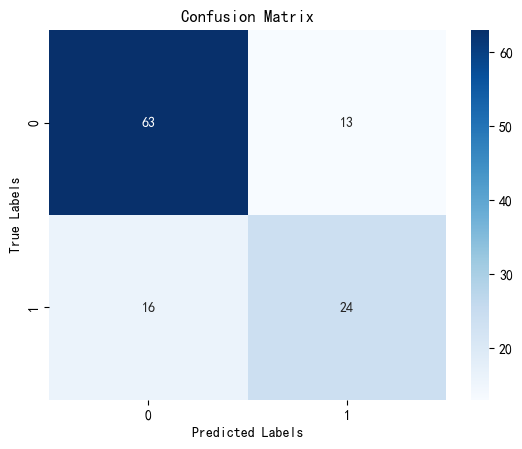

In [7]:
# SVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

# 划分特征和目标变量
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# 特征缩放
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 创建SVM模型并训练
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# 模型预测与评估
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 生成交叉表（混淆矩阵）
confusion_matrix_result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_matrix_result)
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

D:\anacon\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anacon\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anacon\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Glucose')

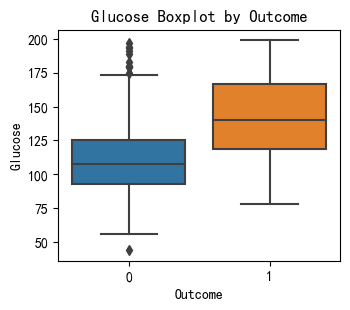

In [8]:
# 设置图片清晰度
plt.rcParams['figure.dpi'] = 100
# 创建画布
plt.figure(figsize=(8, 3))
# 绘制血糖的箱线图（按Outcome分组）
plt.subplot(1, 2, 1)
sns.boxplot(x='Outcome', y='Glucose', data=df)
plt.title('Glucose Boxplot by Outcome')
plt.xlabel('Outcome')
plt.ylabel('Glucose')

D:\anacon\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anacon\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anacon\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Glucose')

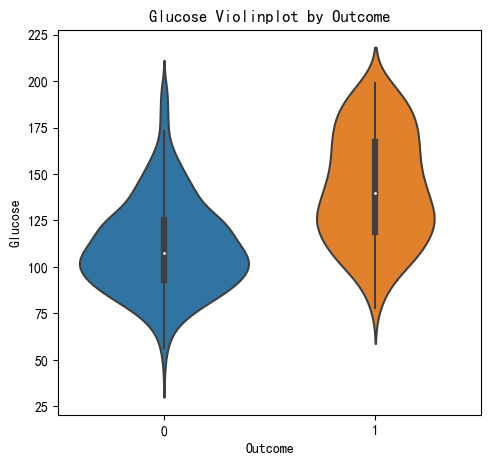

In [9]:
# 创建画布
plt.figure(figsize=(12, 5))
# 绘制血糖的小提琴图（按Outcome分组）
plt.subplot(1, 2, 1)
sns.violinplot(x='Outcome', y='Glucose', data=df)
plt.title('Glucose Violinplot by Outcome')
plt.xlabel('Outcome')
plt.ylabel('Glucose')

In [10]:
# 逻辑回归 
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import classification_report

X = df[df.columns[:-1]]
y = df.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 1)
clf = LogisticRegression()  
# 训练模型  
clf.fit(X_train, y_train)  
# 预测测试集的结果  
y_pred = clf.predict(X_test)   
# 评估模型性能  
print("Accuracy:", clf.score(X_test, y_test))  
print("Classification Report:")  
print(classification_report(y_test, y_pred))

Accuracy: 0.7792207792207793
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        99
           1       0.73      0.60      0.66        55

    accuracy                           0.78       154
   macro avg       0.77      0.74      0.75       154
weighted avg       0.78      0.78      0.77       154



D:\anacon\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
